In [1]:
import csv, os, glob, torch, time
from dataloader.dataset import UnlabeledDataset2, UnlabeledTransform2
import torch.utils.data as data
from utils.module import EarlyStopping
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np

In [20]:
# Uncertainty Scoreを計算
for i in range(5):
    pred_var_path = sorted(glob.glob('data/unlabeled_mask/240114_iter'+str(i+1)+'/pred_var/*'))

    max_box = []
    for file in pred_var_path:
        pred_var = torch.load(file)
        max_box.append(torch.max(pred_var).item())

    print(f'Uncertainty Score : {sum(max_box)/len(max_box)}')

Uncertainty Score : 0.04507634833604663
Uncertainty Score : 0.023909921318990234
Uncertainty Score : 0.02167516100387251
Uncertainty Score : 0.018507482974872064
Uncertainty Score : 0.02157718891129711


In [19]:
# Uncertainty Scoreを計算
for i in range(5):
    pred_var_path = sorted(glob.glob('data/unlabeled_mask/240108_iter'+str(i+1)+'/pred_var/*'))

    max_box = []
    for file in pred_var_path:
        pred_var = torch.load(file)
        max_box.append(torch.max(pred_var).item())

    print(f'Uncertainty Score : {sum(max_box)/len(max_box)}')

Uncertainty Score : 0.09913761172630405
Uncertainty Score : 0.07434127071908861
Uncertainty Score : 0.06523681615957118
Uncertainty Score : 0.05862041263955281
Uncertainty Score : 0.060345435950541815


In [39]:
# Volker Testデータに対し、ドメイン適応前後の出力を比較しoutputsに保存
import torch
import torch.utils.data as data
from dataloader.dataset import OnlyImageDataset
from models.bayesian_deeplab import DeepLabv3plusModel
from models.bayesian_unet import Unet256

image_dir = 'data/Test/images/Volker'
mask_dir = 'data/Test/masks/Volker'
test_dataset = OnlyImageDataset(image_dir)

test_dataloader = data.DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

model_wrapper = DeepLabv3plusModel()
model = model_wrapper.get_model()
# model = Unet256((3, 256, 256))

model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model_path = 'weights/240108/iter3_weights/best.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [40]:
import numpy as np
count = 0
for inputs in test_dataloader:
    inputs = inputs.to(device)
    # outputs = (batch,1,256,256)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)
    # outputs>0.5なら1に、違うなら0に変換
    outputs = (outputs>0.5).float()
    
    for i in range(16):
        input = inputs[i].cpu().numpy().transpose(1, 2, 0)
        output = outputs[i].cpu().numpy().transpose(1, 2, 0)
        output = np.squeeze(output, axis=-1)
        # input画像の上にoutputを重ねる
        pred_img = input.copy()
        pred_img[output==1]=[1,0,0]
        pred_img = (pred_img * 255).astype(np.uint8)
        # 重ねた画像を1枚ずつ保存
        pred_img = Image.fromarray(pred_img)
        pred_img.save(f"outputs/volker_dlsd_after/{count}.png")
        count += 1

In [ ]:
img_files = sorted(glob.glob('data/Test/images/Volker*'))
mask_files = sorted(glob.glob('data/Test/masks/Volker*'))
count = 0

for i in range(96):
    img = cv2.imread(img_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_files[i], cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask>128,1,0)
    
    mask_img = img.copy()
    mask_img[mask==1]=[255,0,0]
    
    mask_img = Image.fromarray(mask_img)
    mask_img.save(f"outputs/volker_mask/{count}.png")
    count += 1

In [ ]:
# PredとAnnotationをプロット、Dice Scoreを表示
anno_path = sorted(glob.glob('data/teacher_split_resized/*'), key=lambda x: (int(os.path.basename(x).split('_')[0].lstrip('c')), int(os.path.basename(x).split('_')[1]), int(os.path.basename(x).split('_')[2].rstrip('.bmp'))))[:4212]
pred_mean_path = sorted(glob.glob('data/unlabeled_mask/231124_iter1/pred_mean/*'), key=lambda x: (int(os.path.basename(x).split('_')[0].lstrip('c')), int(os.path.basename(x).split('_')[1]), int(os.path.basename(x).split('_')[2].rstrip('.jpg'))))

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(4,10))

for i in range(5):
    j = i+1100
    anno = cv2.imread(anno_path[j],0)
    anno = cv2.resize(anno,(256,256))
    pred_mean = cv2.imread(pred_mean_path[j],0)
    
    # 0〜1に変える
    anno = torch.from_numpy(np.where(anno>128, 1, 0))
    pred_mean = torch.from_numpy(np.where(pred_mean>128,1,0))
    
    # Dice Score計算
    anno1 = anno.view(-1)
    pred_mean1 = pred_mean.view(-1)
    intersection = (anno1 * pred_mean1).sum()
    dice_score = (2.*intersection + 1)/(anno1.sum() + pred_mean1.sum() + 1)
    
    accuracy = torch.mean((anno1 == pred_mean1).float())
    
    tp = torch.sum((pred_mean1 == 1) & (anno1 == 1)).float()
    tn = torch.sum((pred_mean1 == 0) & (anno1 == 0)).float()
    fp = torch.sum((pred_mean1 == 1) & (anno1 == 0)).float()
    fn = torch.sum((pred_mean1 == 0) & (anno1 == 1)).float()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'dicescore:{dice_score}, accuracy:{accuracy}, specificity:{specificity}, recall:{recall}, precision:{precision}')

    # Mean
    axes[i, 0].imshow(pred_mean)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Prediction')
    
    # Annotation
    axes[i, 1].imshow(anno,cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Annotation')

plt.tight_layout()
plt.show()

In [ ]:
# pred_varデータを表示
pred_var_path = 'data/unlabeled_mask/231228_iter1/pred_var/00000-0.pnpt'
pred_var = torch.load(pred_var_path)

plt.imshow(pred_var)
plt.axis('off')

In [ ]:
#Volkerラベルなしデータのimage, anno, pred, varをプロット
image_path = sorted(glob.glob('data/Train/images/Volker*'))
anno_path = sorted(glob.glob('data/Train/masks/Volker*'))
pred_mean_path = sorted(glob.glob('data/unlabeled_mask/231224_iter5/pred_mean/*'))
pred_var_path = sorted(glob.glob('data/unlabeled_mask/231224_iter5/pred_var/*'))

In [ ]:
# 同じ順序を保ったままランダムにシャッフル
import numpy as np
combined = list(zip(image_path, anno_path, pred_mean_path, pred_var_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
image_path, anno_path, pred_mean_path, pred_var_path = zip(*combined)

In [ ]:
# 画像の表示
fig, axes = plt.subplots(5, 4, figsize=(7,10))

for i in range(5):
    j = i+300
    print(image_path[j])
    image = plt.imread(image_path[j])
    anno = plt.imread(anno_path[j])
    pred_mean1 = plt.imread(pred_mean_path[j])
    pred_var1 = torch.load(pred_var_path[j])

    # Image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    # Annotation
    axes[i, 1].imshow(anno)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Annotation')

    # Mean
    axes[i, 2].imshow(pred_mean1, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Prediction')

    # Var
    axes[i, 3].imshow(pred_var1)
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Uncertainty')

plt.tight_layout()
plt.show()

In [ ]:
# ラベルなしデータのpred, varをプロット BNN出力を表示
image_path = sorted(glob.glob('data/original_split_resized/*'), key=lambda x: (int(os.path.basename(x).split('_')[0].lstrip('c')), int(os.path.basename(x).split('_')[1]), int(os.path.basename(x).split('_')[2].rstrip('.jpg'))))[:4212]
anno_path = sorted(glob.glob('data/teacher_split_resized/*'), key=lambda x: (int(os.path.basename(x).split('_')[0].lstrip('c')), int(os.path.basename(x).split('_')[1]), int(os.path.basename(x).split('_')[2].rstrip('.bmp'))))[:4212]
pred_mean_path = sorted(glob.glob('data/unlabeled_mask/231215_iter1/pred_mean/*'), key=lambda x: (int(os.path.basename(x).split('_')[0].lstrip('c')), int(os.path.basename(x).split('_')[1]), int(os.path.basename(x).split('_')[2].rstrip('.jpg'))))
pred_var_path = sorted(glob.glob('data/unlabeled_mask/231215_iter1/pred_var/*'), key=lambda x: (int(os.path.basename(x).split('_')[0].lstrip('c')), int(os.path.basename(x).split('_')[1]), int(os.path.basename(x).split('_')[2].rstrip('.pt'))))

In [ ]:
filenames = ['c17_1_3.jpg','c49_3_2.jpg','c33_1_7.jpg','c74_0_3.jpg','c24_5_5.jpg',
             'c68_0_4.jpg','c68_2_7.jpg','c28_0_2.jpg','c14_2_7.jpg','c39_1_3.jpg']
image_path = ['data/original_split_resized/'+f for f in filenames]
anno_path = ['data/teacher_split_resized/'+f.rstrip('jpg')+'bmp' for f in filenames]
pred_mean_path = ['data/unlabeled_mask/231215_iter3/pred_mean/'+f for f in filenames]
pred_var_path = ['data/unlabeled_mask/231215_iter3/pred_var/'+f.rstrip('jpg')+'pt' for f in filenames]

In [ ]:
# 同じ順序を保ったままランダムにシャッフル
import numpy as np
combined = list(zip(image_path, anno_path, pred_mean_path, pred_var_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
image_path, anno_path, pred_mean_path, pred_var_path = zip(*combined)

In [ ]:
# 画像の表示
fig, axes = plt.subplots(5, 4, figsize=(7,10))

for i in range(5):
    j = i
    print(image_path[j])
    image = plt.imread(image_path[j])
    anno = plt.imread(anno_path[j])
    pred_mean1 = plt.imread(pred_mean_path[j])
    pred_var1 = torch.load(pred_var_path[j])

    # Image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    # Annotation
    axes[i, 1].imshow(anno)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Annotation')

    # Mean
    axes[i, 2].imshow(pred_mean1, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Prediction')

    # Var
    axes[i, 3].imshow(pred_var1)
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Uncertainty')

plt.tight_layout()
plt.show()

In [ ]:
#sdimgに対して、擬似ラベルとその不確実性を見る
import glob
image_path = sorted(glob.glob('data/2023-12-25/*'))
pred_mean_path = sorted(glob.glob('data/unlabeled_mask/240114_iter1/pred_mean/*'))
pred_var_path = sorted(glob.glob('data/unlabeled_mask/240114_iter1/pred_var/*'))

In [ ]:
# 画像の表示
fig, axes = plt.subplots(5, 3, figsize=(5,10))

for i in range(5):
    j = i+100
    print(image_path[j])
    image = plt.imread(image_path[j])
    pred_mean1 = plt.imread(pred_mean_path[j])
    pred_var1 = torch.load(pred_var_path[j])

    # Image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    # Mean
    axes[i, 1].imshow(pred_mean1, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Prediction')

    # Var
    axes[i, 2].imshow(pred_var1)
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Uncertainty')

plt.tight_layout()
plt.show()

In [33]:
# 6000x3000画像に対してひび割れ検出を行う
import torch
import torch.utils.data as data
from dataloader.dataset import PanoImageDataset
from models.bayesian_deeplab import DeepLabv3plusModel
from models.bayesian_unet import Unet256

image_dir = 'data/original_split_resized/'
file = 'c95'
mask_dir = 'data/teacher_split_resized/'
test_dataset = PanoImageDataset(image_dir, file)

test_dataloader = data.DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

model_wrapper = DeepLabv3plusModel()
model = model_wrapper.get_model()
# model = Unet256((3, 256, 256))

model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model_path = 'weights/240114/iter5_weights/best.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

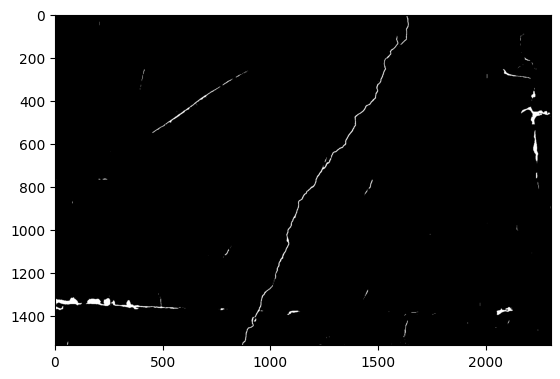

In [34]:
import numpy as np
count = 0
pred_mask = np.zeros((1536,2304))
for inputs in test_dataloader:
    inputs = inputs.to(device)
    # outputs = (batch,1,256,256)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)
    
    for i in range(outputs.size(0)):
        # predは(256,256)
        pred = outputs[i].cpu().detach().numpy()[0]
        pred = np.where(pred >= 0.5, 1, 0)
        
        row, col = count//9, count%9
        pred_mask[row*256:(row+1)*256, col*256:(col+1)*256] = pred
        count += 1

plt.imshow(pred_mask, cmap='gray')

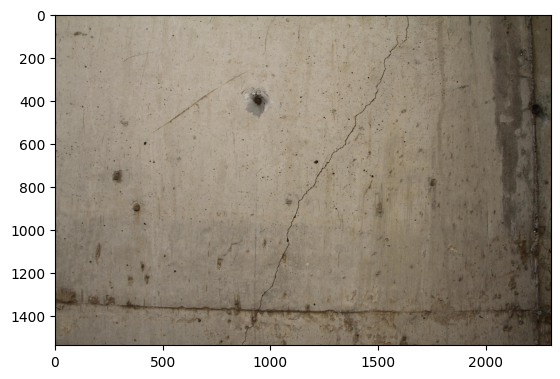

In [35]:
from PIL import Image
image_files = glob.glob(image_dir + file + '*')
image_files = sorted(image_files, key=lambda x: (int(x.split('_')[3]), int(x.split('_')[4].rstrip('.jpg'))))

image = np.ones((1536,2304,3),dtype=np.uint8)
for count in range(len(image_files)):
    img = Image.open(image_files[count])
    img = img.resize((256,256))
    img = np.array(img)
    row, col = count//9, count%9
    image[row*256:(row+1)*256, col*256:(col+1)*256, :] = img
    
plt.imshow(image)

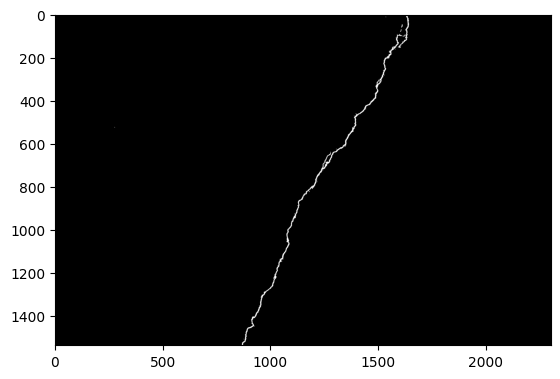

In [36]:
mask_files = glob.glob(mask_dir + file + '*')
mask_files = sorted(mask_files, key=lambda x: (int(x.split('_')[3]), int(x.split('_')[4].rstrip('.bmp'))))

mask = np.ones((1536,2304),dtype=np.uint8)
for count in range(len(mask_files)):
    msk = Image.open(mask_files[count]).convert('L')
    msk = msk.resize((256,256))
    msk = np.array(msk)
    msk = np.where(msk >= 0.5, 1, 0)
    row, col = count//9, count%9
    mask[row*256:(row+1)*256, col*256:(col+1)*256] = msk
    
plt.imshow(mask,cmap='gray')

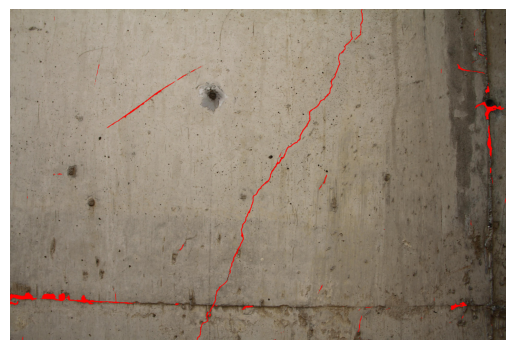

In [37]:
# 出力画像の表示
pred_img = image.copy()
pred_img[pred_mask==1]=[255,0,0]
plt.axis('off')
plt.imshow(pred_img)

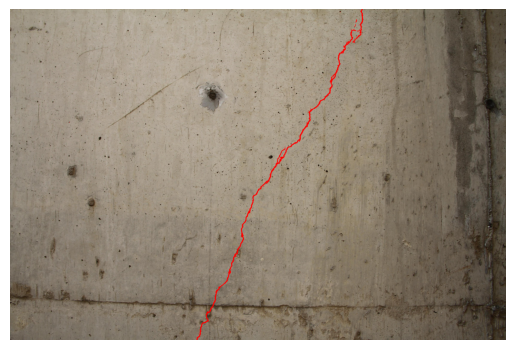

In [38]:
# マスク画像の出力
mask_img = image.copy()
mask_img[mask==1]=[255,0,0]
plt.axis('off')
plt.imshow(mask_img)

In [ ]:
# モデルのtest dataでの出力をプロットする
import torch
import torch.utils.data as data
from dataloader.dataset import make_datapath_list, make_datapath_list_supervised, LabeledDataset, ValLabeledTransform
from models.bayesian_deeplab import DeepLabv3plusModel

makepath = make_datapath_list('hoge', first=True)
test_img_list, test_anno_list = makepath.get_list("test")
test_dataset = LabeledDataset(test_img_list, test_anno_list, transform=ValLabeledTransform(crop_size=256))
test_dataloader = data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

model_wrapper = DeepLabv3plusModel()
model = model_wrapper.get_model()

model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
model2 = model_wrapper.get_model()

model2 = torch.nn.DataParallel(model2, device_ids=[0, 1, 2, 3])
model2 = model2.to(device)

In [ ]:
model_path = 'weights/231124/iter1_weights/best.pth'
model.load_state_dict(torch.load(model_path))
model2_path = 'weights/231124/iter4_weights/best.pth'
model2.load_state_dict(torch.load(model2_path))

with torch.no_grad():
    for image,mask in test_dataloader:
        image = image.to(device,dtype=torch.float)
        mask = mask.to(device,dtype=torch.float)

        pred = torch.sigmoid(model.forward(image))
        pred2 = torch.sigmoid(model2.forward(image))
        break

In [ ]:
print(image.shape)
print(mask.shape)
print(pred.shape)

In [ ]:
# datasetがrissbilになてる
import torchvision.transforms.functional as F

# 3つの画像を横に並べる
fig, axes = plt.subplots(16, 3, figsize=(12,64))

for i in range(16):
    im = F.to_pil_image(image[i])
    ma = F.to_pil_image(mask[i])
    pr = F.to_pil_image(pred[i])

    # 1番目のサブプロットにオリジナルの画像を表示
    axes[i,0].imshow(im)
    axes[i,0].set_title('Original Image')
    axes[i,0].axis('off')

    # 2番目のサブプロットにマスクを表示
    axes[i,1].imshow(pr, cmap='gray')
    axes[i,1].set_title('Prediction')
    axes[i,1].axis('off')

    # 3番目のサブプロットに予測を表示
    axes[i,2].imshow(ma, cmap='gray')
    axes[i,2].set_title('Label')
    axes[i,2].axis('off')

# 画像を表示
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
import torchvision.transforms.functional as F

# 3つの画像を横に並べる
fig, axes = plt.subplots(16, 3, figsize=(12,64))

for i in range(16):
    im = F.to_pil_image(image[i])
    ma = F.to_pil_image(mask[i])
    pr = F.to_pil_image(pred2[i])

    # 1番目のサブプロットにオリジナルの画像を表示
    axes[i,0].imshow(im)
    axes[i,0].set_title('Original Image')
    axes[i,0].axis('off')

    # 2番目のサブプロットにマスクを表示
    axes[i,1].imshow(pr, cmap='gray')
    axes[i,1].set_title('Prediction')
    axes[i,1].axis('off')

    # 3番目のサブプロットに予測を表示
    axes[i,2].imshow(ma, cmap='gray')
    axes[i,2].set_title('Label')
    axes[i,2].axis('off')

# 画像を表示
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
# 231217のpred_mean, pred_mean_correctedを二つ並びで表示
pred_mean_path = sorted(glob.glob('data/unlabeled_mask/231217_iter1/pred_mean/*'))
pred_meco_path = sorted(glob.glob('data/unlabeled_mask/231217_iter1/pred_mean_corrected/*'))

In [ ]:
# 同じ順序を保ったままランダムにシャッフル
import numpy as np
combined = list(zip(pred_mean_path, pred_meco_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
pred_mean_path, pred_meco_path = zip(*combined)

In [ ]:
# 画像の表示
fig, axes = plt.subplots(10, 2, figsize=(4,10))

for i in range(10):
    j = i
    pred_mean = plt.imread(pred_mean_path[j])
    pred_meco = plt.imread(pred_meco_path[j])
    if np.array_equal(pred_mean,pred_meco):
        continue

    # Mean
    axes[i, 0].imshow(pred_mean, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Before screening')

    # Var
    axes[i, 1].imshow(pred_meco, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('After screening')

plt.tight_layout()
plt.show()

In [ ]:
# ラベルなしデータのpred, varをプロット
image_path = sorted(glob.glob('data/Train/images/Volker*'))
anno_path = sorted(glob.glob('data/Train/masks/Volker*'))
pred_mean1_path = sorted(glob.glob('data/unlabeled_mask/231128_iter1/pred_mean_corrected/*'))
pred_var1_path = sorted(glob.glob('data/unlabeled_mask/231128_iter1/pred_var/*'))

In [ ]:
# 同じ順序を保ったままランダムにシャッフル
import numpy as np
combined = list(zip(image_path, anno_path, pred_mean1_path, pred_var1_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
image_path, anno_path, pred_mean1_path, pred_var1_path = zip(*combined)

In [ ]:
# 画像の表示
fig, axes = plt.subplots(5, 4, figsize=(10,10))

for i in range(5):
    j = i
    image = plt.imread(image_path[j])
    anno = plt.imread(anno_path[j])
    pred_mean1 = plt.imread(pred_mean1_path[j])
    pred_var1 = torch.load(pred_var1_path[j])

    # Image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    # Annotation
    axes[i, 1].imshow(anno)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Annotation')

    # Mean
    axes[i, 2].imshow(pred_mean1, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Mean')

    # Var
    axes[i, 3].imshow(pred_var1, cmap='gray')
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Var')

plt.tight_layout()
plt.show()

In [ ]:
import random
# 各データセットの画像例を(2,3)でプロット
image_path = sorted(glob.glob('data/Train/images/[!Rissbilder]*'))
image_path2 = sorted(glob.glob('data/Train/images/Rissbilder*'))

# ランダムに6つの画像を選択
selected_images = random.sample(image_path2, 6)

# 2行3列に並べて表示
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i, image in enumerate(selected_images):
    # 画像を読み込み
    img = Image.open(image)

    # サブプロットに画像を表示
    row = i // 3
    col = i % 3
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [ ]:
# ソース（変換前）、ソース（変換後）、アノテーションをプロット
sourceb_path = sorted(glob.glob('data/Test/images/[!Rissbilder]*'))
sourcea_path = sorted(glob.glob('data/Test_transform2/images/[!Rissbilder]*'))
anno_path = sorted(glob.glob('data/Test/masks/[!Rissbilder]*'))

In [ ]:
# 同じ順序を保ったままランダムにシャッフル
combined = list(zip(sourceb_path, sourcea_path, anno_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
sourceb_path, sourcea_path, anno_path = zip(*combined)

In [ ]:
# 画像の表示
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i in range(5):
    j = i + 10
    image1 = plt.imread(sourceb_path[j])
    image2 = plt.imread(sourcea_path[j])
    anno = plt.imread(anno_path[j])


    # Image
    axes[i, 0].imshow(image1)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image Before')
    
    # Image
    axes[i, 1].imshow(image2)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Image After')

    # Annotation
    axes[i, 2].imshow(anno, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Annotation')


plt.tight_layout()
plt.show()